DFM / online-coupled bloom tracer Run
--

This version matches with run_dfm_bloom_tracers_v01 / bloom_tracers_v02.

Include 3 swimming speeds (0,10,20 m/d), no temperature, and initialization
from 8/4 imagery.

In [108]:
import matplotlib.pyplot as plt
%matplotlib widget

In [109]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")
from stompy import utils
import stompy.model.delft.dflow_model as dfm
import stompy.model.delft.waq_scenario as dwaq
from stompy.plot import plot_utils, plot_wkb
from stompy.grid import unstructured_grid
from matplotlib import colors
import pandas as pd
import os
import numpy as np
import xarray as xr
import subprocess
from scipy.integrate import solve_ivp
from numba import njit

from IPython.display import Video
import time
import six
import datetime
import glob
from stompy.plot import nbviz

In [3]:
# These online-coupled dfm-dwaq runs.

# Spinup
#run_dir="bloom_tracers_v02/run_20220801T0000_20220804T1820_v02"
# Main run
run_dir="bloom_tracers_v02/run_20220804T1820_20220830T0000_v00"
model=dfm.DFlowModel.load(run_dir)

swim_speeds=[0,10,20]

In [4]:
ds=model.map_dataset()

In [5]:
ds.reload()

In [6]:
grid=ds.grid
#()unstructured_grid.UnstructuredGrid.read_ugrid(ds)
#from stompy.plot import plot_wkb
grid_poly=grid.boundary_polygon()

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
/richmondvol1/rusty/stompy/stompy/spatial/join_features.py:514: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.join_id=i
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=3212664407.249223, 15 potential interiors


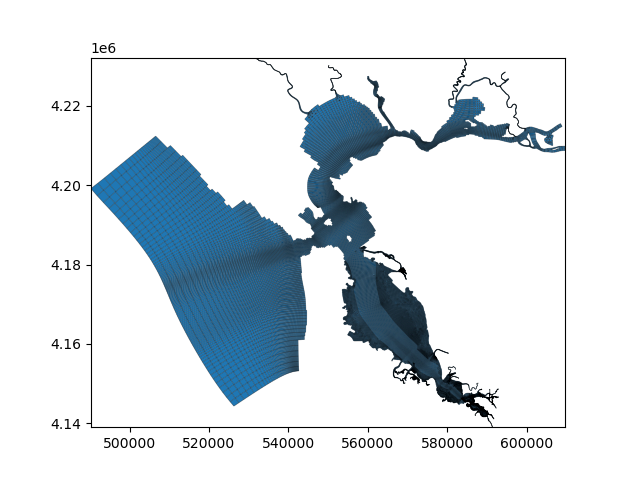

In [7]:
# Is the initial condition not in there? mostly nan, a few 0 values
# in seemingly super-tidal cells.
fig,ax=plt.subplots()
grid.plot_edges(color='k',lw=0.5,alpha=0.4)
grid.plot_cells(mask=np.isfinite(ds['conc0'].isel(time=1,laydim=0)))

In [8]:
if 0: # old debugging. proc 14 and 15 had a lot of nan...
    fig,ax=plt.subplots()
    grid.plot_edges(color='k',lw=0.5,alpha=0.5)
    
    for fn in model.restart_inputs():
        rst_ds=xr.open_dataset(os.path.join(model.run_dir,fn))
        nancount = np.isnan(rst_ds['conc0'].values).sum()
        print(f"{fn}: nan count {nancount}")
        if nancount>0:
            xy=np.c_[rst_ds.FlowElem_xzw.values, rst_ds.FlowElem_yzw.values]
            sel=np.isnan(rst_ds['conc0'].isel(time=0,laydim=0).values)
            ax.plot(xy[sel,0],xy[sel,1],label=fn)
    ax.legend()

In [9]:
def ratio(a,b,b_min=1e-8):
    return a/b.clip(b_min) * np.where(b<b_min,np.nan, 1.0)

In [10]:
frac=0.1
M=grid.smooth_matrix()
def fill(values,iterations=50):
    valid=np.isfinite(values)
    data=np.where(valid,values,0.0)
    weight=np.where(valid,1,0.0)
    for _ in range(iterations):
        data=M.dot(data)
        weight=M.dot(weight)
        data[valid]=values[valid]
        weight[valid]=1.0
    result=np.full(len(values),np.nan)
    valid=weight>1e-4
    result[valid]=data[valid]/weight[valid]
    return result

INFO:utils:83656/86633


Checking swim results
--

Looks like setting swimming via DFM is working, and the age/depth/radiation tracers
give reasonable results.

In [11]:
groups=[0,1,2]


/tmp/ipykernel_1839912/536938404.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  colls.append( ax.pcolormesh( conc.time, z, conc.values.T, cmap='turbo', shading='nearest') )


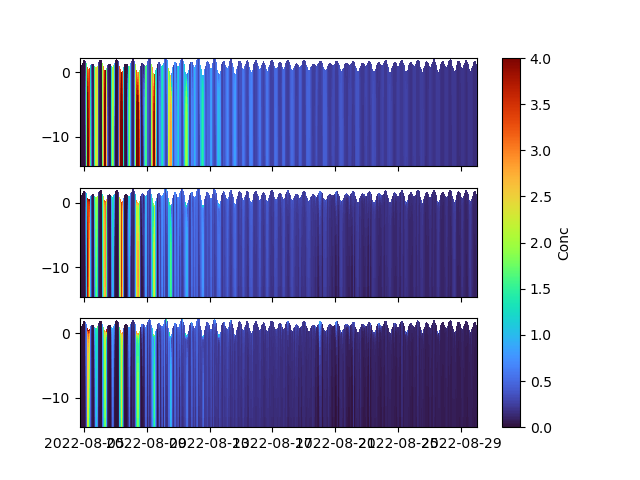

In [12]:
# Check to see whether upward swimming is working, and if age/property tracers are working.
point=[557240,4185530] # SE of Treasure Island.
c=ds.grid.select_cells_nearest(point)


fig,axs=plt.subplots(len(groups),1,sharex=True,sharey=True)

z=-ds['FlowElem_zcc'].isel(nFlowElem=c) + ds['LayCoord_cc'] * ds['waterdepth'].isel(nFlowElem=c)

colls=[]
for ax,g in zip(axs,groups):
    conc = ds[f'conc{g}'].isel(nFlowElem=c)
    colls.append( ax.pcolormesh( conc.time, z, conc.values.T, cmap='turbo', shading='nearest') )

plt.setp(colls[:-1], clim=colls[-1].get_clim()) 
plt.colorbar( colls[0], ax=axs, label="Conc")

/tmp/ipykernel_1839912/1403006240.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  colls.append( ax.pcolormesh( ds.time, z, rad.values.T, cmap='turbo', shading='nearest') )
/tmp/ipykernel_1839912/1403006240.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  colls.append( ax.pcolormesh( ds.time, z, rad.values.T, cmap='turbo', shading='nearest') )
/tmp/ipykernel_1839912/1403006240.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in whic

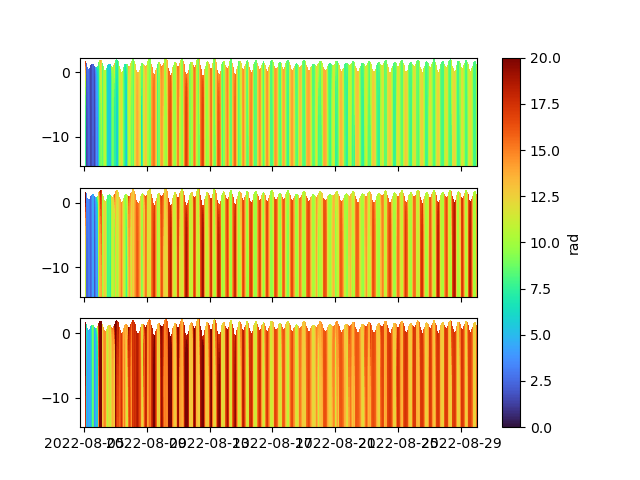

In [13]:
# Similar, but check on rad

fig,axs=plt.subplots(len(groups),1,sharex=True,sharey=True)

colls=[]
for ax,g in zip(axs,groups):
    radc = ds[f'radc{g}'].isel(nFlowElem=c)
    conc = ds[f'conc{g}'].isel(nFlowElem=c)
    age=(ds.time - ds.time.values[0])/np.timedelta64(1,'D')    
    rad=ratio(radc, conc*age, 1e-5)

    colls.append( ax.pcolormesh( ds.time, z, rad.values.T, cmap='turbo', shading='nearest') )
    
plt.setp(colls, clim=[0,20])
plt.colorbar( colls[0], ax=axs, label="rad")

Plotting All Fields
--

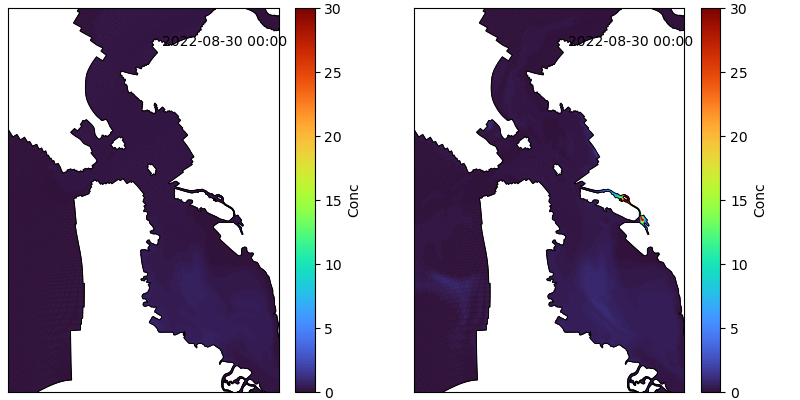

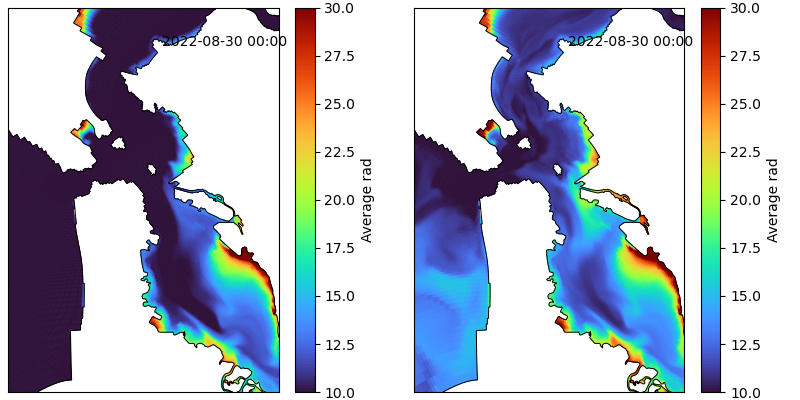

In [14]:
tidx=-1

plots=[
    dict(label='Conc', clim=[0,30], data_fn=lambda snap,g: snap[f'conc{g}']),
    #dict(label='$log_{10}$ Conc', clim=[-4,0], data_fn=lambda snap,g: np.log10(snap[f'conc{g}'].values.clip(1e-4))),
    dict(label='Average rad', clim=[10,30],data_fn=lambda snap,g: ratio( snap[f'radc{g}'].values, age*snap[f'conc{g}'].values, 1e-5)),
    #dict(label="Depth exposure (m)", clim=[0,10], data_fn=lambda snap,g: ratio(snap[f'depc{g}'].values, snap[f'agec{g}'].values,1e-5)),    
    #dict(label="Age (d)", clim=[0,15], data_fn=lambda snap,g: ratio(snap[f'agec{g}'].values, snap[f'conc{g}'].values,1e-5)),         
]

snap2d=ds.isel(time=tidx,laydim=-1)
age=(snap2d.time.values - ds.time.values[0])/np.timedelta64(1,'D')

for plot in plots: 
    fig,axs=plt.subplots(1,2,figsize=(8,4))
    for g,ax in enumerate(axs):
        ax.set_adjustable('datalim')
        fig.subplots_adjust(left=0.01, right=0.94, top=0.98, bottom=0.02)
        ax.xaxis.set_visible(0)
        ax.yaxis.set_visible(0)    
        kw=dict(lw=0.5,edgecolor='face', cmap='turbo')    
        scal=plot['data_fn'](snap2d,g) 
                
        ccoll=ds.grid.plot_cells( values=scal, clim=plot['clim'], ax=ax, **kw)
        plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.7,ax=ax)
        plt.colorbar(ccoll,label=plot['label'],ax=ax)
        ax.axis((532541.1781775085, 575394.0337062994, 4160999.923094737, 4202393.6312130485))
        ax.text(0.57,0.9, utils.strftime(snap2d.time.values), transform=ax.transAxes)

In [15]:
from stompy import memoize

@memoize.memoize(lru=1)
def extract_tracers(tidx,layer,Isat=30.0,thresh=1e-5,group=0):
    """
    layer: mean, surface, integrated, or a laydim index 0=bed, 15=surface
    layer=mean is not necessarily what you want! That averages light exposure
    over the layers.
    layer=integrated will keep the layers intact. Not implemented.
    """
    # Extraction
    # instantaneous release, so age is a given.
    t=ds.time.isel(time=tidx).values
    age_d = (t - ds.time.values[0]) / np.timedelta64(86400,'s')

    assert layer!='integrated',"Not implemented"
    if layer in ['mean']:
        snap=ds.isel(time=tidx)
        conc = snap[f'conc{group}'].values.mean(axis=1).clip(0,np.inf)
    else:
        snap=ds.isel(time=tidx,laydim=layer)
        conc  = snap[f'conc{group}'].values

    # These should be about the same, not sure why one would be preferable over the
    # other.
    #Imean =  ratio( snap['radc0'].values, snap['agec0'].values, thresh)
    # 1.85 = 0.45 total->PAR correction, 4.57 W -> uEin/s conversion, 0.90 -> surface albedo correction.
    Imean = 1.85 * ratio( snap[f'radc{group}'].values, snap[f'conc{group}'].values*age_d, thresh)
            
    kLight = (Imean/(Imean + Isat))
    if layer=='mean':
        kLight = kLight.mean(axis=1) # happen to know that layer is the second dimension    

    Imean[np.isnan(Imean)]=0.0 
    kLight = fill(kLight, iterations=120)
    return dict(age_d=age_d, conc=conc, kLight=kLight, Imean=Imean, t=t, depth=snap['waterdepth'].values)  


In [16]:
#sample_xy = [561890, 4173260]
#sample_c=ds.grid.select_cells_nearest(sample_xy) # 24893

In [17]:
# Panel for P and a panel for N.
import time

# 
# alpha=0.15, # stoichiometry, uM DIN per ug/l chl production.
# DS has used 1:1.
# Say you start with Redfield.
# C:N  106:16 => 6.6 uM C : uM N  * 12 ugC : 1 uM
# If I initialized the area as 250..
# 30 * 8 => 250, which was actually uM C
# 250 uM C/l * 12 ug/uM ==> 3000 ug C/l
# * 1chl/30C = 100 ug/l
# 
# C:chl ~ 20?



def solveNP(thresh=1e-5,
            # Parameters:
            c0 = 50,
            tidx = 20, 
            Isat=20., 
            N0=35, # initial DIN
            Nsat=0.5,
            kprod=0.6, # 
            kmort=0.1,
            alpha=0.15, # stoichiometry, uM DIN per uM C (wrongly labeled ug/l chl before)
            layer='mean',
            clip=None, # still returns full grid output, padded with nan.
            group=0):
    tracers=extract_tracers(tidx=tidx, layer=layer, Isat=Isat,thresh=thresh,group=group)
    
    kLight = tracers['kLight']
    conc = c0*tracers['conc']
    age_d = tracers['age_d']
    Imean = tracers['Imean']
    t = tracers['t']

    sel = np.isfinite(kLight * conc * age_d)
    if clip is not None:
        sel = sel & ds.grid.cell_clip_mask(clip,False)
    kLight = kLight[sel]
        
    # ODE integration
    # State vector is [ P[0].... P[i], N[0], ... , N[i] ]
    def diff(t,state):
        P,N=state.reshape([2,-1])
        N=N.clip(0) # no evidence this is really necessary
        P=P.clip(0) # likewise.
        kDIN=N/(N+Nsat)
        dgrossP = kprod*kLight*kDIN*P
        dnetP = -kmort*P + dgrossP
        dN = -alpha*dgrossP
        mu_net = kprod*kLight*kDIN - kmort
        return np.r_[dnetP,dN]
    IC=np.r_[conc[sel], N0*np.ones_like(conc)[sel]]

    print("IC shape: ", IC.shape) # 2*Ncells
    
    # odeint was buggy.
    #result = odeint(diff, IC, [0,age_d], hmax=0.1)
    bunch = solve_ivp(diff, y0=IC, t_span=[0,age_d])
    result=bunch.y[:,-1]
    Psel,Nsel = result.reshape([2,-1])
    # expand
    P = np.full(conc.shape,0.0)
    N = np.full(conc.shape,N0)
    P[sel]=Psel
    N[sel]=Nsel
    
    result=xr.Dataset()
    result['N'] = ('cell',), N
    result['P'] = ('cell',), P
    result['time'] = (),t
    result['swiming']= (),swim_speeds[group]
    result['depth'] = ('cell',), tracers['depth']
    return result

IC shape:  (58448,)
IC shape:  (58422,)


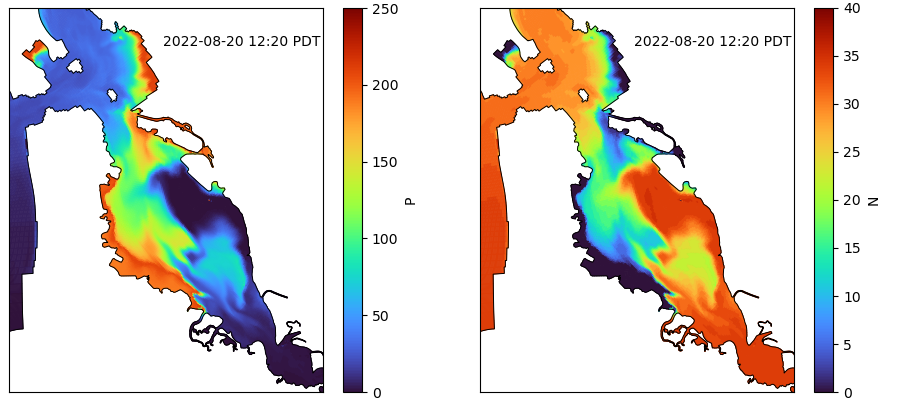

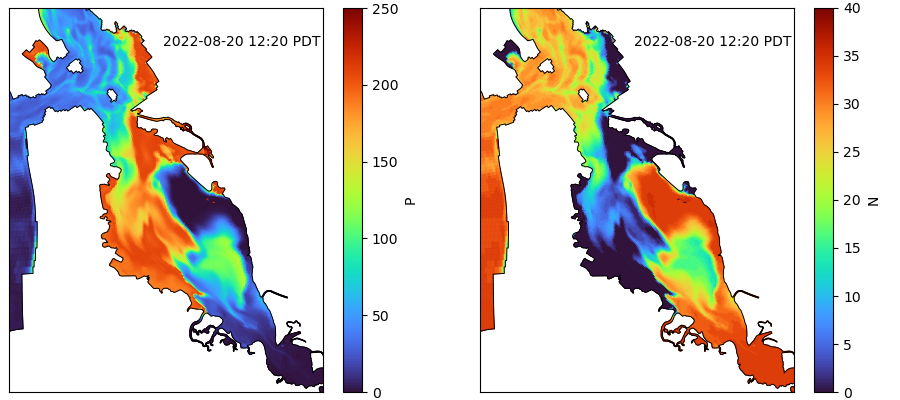

In [106]:
import matplotlib.colorbar as cbar
zoom=(540604.0430344798, 585428.0850690929, 4144192.2487012795, 4198977.188965806)

depth_integrated=False

group=1
if depth_integrated:
    layer='mean'
else:
    layer='mean'

for group in [0,1]:
    result = solveNP(tidx=385,
                     c0 = 8,
                     Isat=30., # 30 uMol photons / m2 /s
                     N0=35, # initial DIN
                     Nsat=1.0,
                     kprod=0.65, # 
                     kmort=0.03,
                     clip=zoom,
                     group=group,
                     layer=layer)
    
    fig,axs=plt.subplots(1,2,figsize=(9,4))
    fig.subplots_adjust(left=0.01, right=0.97, top=0.98, bottom=0.02)
    axP,axN = axs
    caxs=[cbar.make_axes(ax)[0] for ax in axs]
    
    kw=dict(lw=0.5,edgecolor='face', cmap='turbo')

    panels=[]
    if depth_integrated:
        panels.append( dict(scal=result.P * result.depth,label='P integrated',clim=[0,1000]) )
    else:
        panels.append( dict(scal=result.P,label='P',clim=[0,250]) )
        
    panels.append( dict(scal=result.N,label='N',clim=[0,40]))
    
    for ax,cax,plot in zip(axs,caxs,panels):
        ax.set_adjustable('datalim')
        ax.xaxis.set_visible(0)
        ax.yaxis.set_visible(0)    
        ccoll=ds.grid.plot_cells( values=plot['scal'], ax=ax,**kw)
        ccoll.set_clim(plot['clim'])
        plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.7,ax=ax)
        plt.colorbar(ccoll,label=plot['label'],cax=cax)
        # ax.axis((532541.1781775085, 575394.0337062994, 4160999.923094737, 4202393.6312130485))
        ax.axis(zoom)
        ax.text(0.49,0.9, utils.strftime(result.time-np.timedelta64(7,'h'))+" PDT",
                transform=ax.transAxes)
    

In [84]:
# tide, insolation time series
@memoize.memoize()
def cimis():
    print("Reloading cimis")
    cimis_ds=xr.open_dataset('/richmondvol1/hpcshared/inputs/cimis/union_city-hourly-2022_bloom.nc')
    # Starts as PST, but the model is UTC.
    cimis_ds=cimis_ds.set_coords('time').swap_dims({'Date':'time'})
    cimis_ds['time']=cimis_ds['time']+np.timedelta64(8,'h')
    sol_rad=cimis_ds['HlySolRad'].values
    sol_rad=utils.fill_invalid(sol_rad)
    cimis_ds['sol_rad']=('time',),sol_rad
    sel = utils.select_increasing(cimis_ds.time.values)
    return 1.85*cimis_ds['sol_rad'].isel(time=sel)

c=ds.grid.select_cells_nearest([564400,4161700])
tides_da = ds['s1'].isel(nFlowElem=c)


def tide_panel(ax,t):
    t_off=np.timedelta64(7,'h') # PDT
    da_cimis = cimis()
    ax.fill_between(da_cimis.time-t_off,da_cimis, color='orange', lw=0.8) # fc='#eeee00', ec='#eeee00',lw=0.8) 
    ax_tides=ax.twinx()
    ax_tides.plot(tides_da.time-t_off, tides_da,lw=1.25)
    ax_tides.yaxis.set_visible(0)
    #ax.yaxis.set_visible(0)
    ax_tides.axis('off')
    ax.axis(ymin=0,ymax=2000,xmin=ds.time.values[0]-t_off,xmax=ds.time.values[-1]-t_off)
    ax.axvline(t-t_off,color='k',lw=1.25)
    plt.setp(ax.get_xticklabels(),visible=0)

#fig,ax=plt.subplots(figsize=(8,1.3))
#tide_panel(ax,ds.time.values[385])

In [ ]:
# Animation
import subprocess

fig=plt.figure(figsize=(8,4))

#zoom=(540604.0430344798, 585428.0850690929, 4144192.2487012795, 4198977.188965806)
zoom=(543077.3805958533, 583305.1687229705, 4147985.840441021, 4193524.9537192974)

for group in [0,1,2]:
    swim=swim_speeds[group]

    # MODIFIED
    frame_dir=os.path.join(run_dir,f"frames_w{swim:02.0f}_Isat250")
    if not os.path.exists(frame_dir):
        os.makedirs(frame_dir)    
    
    for tidx in range(ds.dims['time']):
        img_fn=os.path.join(frame_dir,"frame_%04d.png"%tidx)
        fig.clf()
        axs=fig.subplots(1,2)

        fig.subplots_adjust(left=0.01, right=0.97, top=0.98, bottom=0.14, wspace=0.07)
        axP,axN = axs
        caxs=[cbar.make_axes(ax)[0] for ax in axs]
        
        for ax in axs:
            ax.set_adjustable('datalim')
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)    

        ax_tide = fig.add_axes([axs[0].get_position().xmin,0.01,
                                axs[1].get_position().xmax - axs[0].get_position().xmin, 0.12])

        if os.path.exists(img_fn): continue
        
        result = solveNP(tidx=tidx,
                         c0 = 8,
                         Isat=250., # MODIFIED 
                         N0=35, # initial DIN
                         Nsat=0.5,
                         kprod=0.65, # 
                         kmort=0.08,
                         clip=zoom,
                         group=group,layer=-1)
        
        axP.cla()
        axN.cla()
        
        kw=dict(lw=0.5,edgecolor='face', cmap='turbo')
        
        for ax,cax,plot in zip(axs,caxs,[
            dict(scal=result.P,label='P',clim=[0,250]),
            dict(scal=result.N,label='N',clim=[0,40])
        ]):
            ax.cla()
            cax.cla()
            
            ccoll=ds.grid.plot_cells( values=plot['scal'], ax=ax,**kw)
            ccoll.set_clim(plot['clim'])
            plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.7,ax=ax)
            plt.colorbar(ccoll,label=plot['label'],cax=cax)
            # ax.axis((532541.1781775085, 575394.0337062994, 4160999.923094737, 4202393.6312130485))
            ax.axis(zoom)
            if ax==axs[0]:
                ax.text(0.54,0.9, utils.strftime(result.time-np.timedelta64(7,'h')) + "\nPDT",
                        transform=ax.transAxes)
        tide_panel(ax_tide,ds.time.values[tidx])
        ax_tide.axis('off')
        fig.savefig(img_fn,dpi=100)
    
    # animation
    movie_fn=os.path.join(frame_dir,"movie.mp4")
    
    # Compile to animation
    if os.path.exists(movie_fn):
        os.unlink(movie_fn)
    subprocess.run(f"ffmpeg -framerate 10 -i {os.path.join(frame_dir,'frame_%04d.png')} "
                    "-c:v libx264 -preset slow -profile:v high -level:v 4.0 "
                   f"-pix_fmt yuv420p -crf 20 -r 10 {movie_fn}",
                   shell=True)
    


IC shape:  (0,)
IC shape:  (7020,)
IC shape:  (7886,)
IC shape:  (9162,)
IC shape:  (10258,)
IC shape:  (11302,)
IC shape:  (12342,)
IC shape:  (13226,)
IC shape:  (13934,)
IC shape:  (14390,)
IC shape:  (14406,)
IC shape:  (14054,)
IC shape:  (13838,)
IC shape:  (14050,)
IC shape:  (14542,)
IC shape:  (15392,)
IC shape:  (16464,)
IC shape:  (17218,)
IC shape:  (17880,)
IC shape:  (18072,)
IC shape:  (17894,)
IC shape:  (17540,)
IC shape:  (17032,)
IC shape:  (16650,)
IC shape:  (16484,)
IC shape:  (16598,)
IC shape:  (16936,)
IC shape:  (17980,)
IC shape:  (19276,)
IC shape:  (20596,)
IC shape:  (21420,)
IC shape:  (21616,)
IC shape:  (21388,)
IC shape:  (20804,)
IC shape:  (19704,)
IC shape:  (18442,)
IC shape:  (17368,)
IC shape:  (16750,)
IC shape:  (16630,)
IC shape:  (17070,)
IC shape:  (18062,)
IC shape:  (19004,)
IC shape:  (20022,)
IC shape:  (20820,)
IC shape:  (21102,)
IC shape:  (21064,)
IC shape:  (20670,)
IC shape:  (20050,)
IC shape:  (19596,)
IC shape:  (19236,)
IC shap

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

IC shape:  (0,)
IC shape:  (7030,)
IC shape:  (7908,)
IC shape:  (9172,)
IC shape:  (10268,)
IC shape:  (11386,)
IC shape:  (12392,)
IC shape:  (13346,)
IC shape:  (14030,)
IC shape:  (14460,)
IC shape:  (14468,)
IC shape:  (14106,)
IC shape:  (13934,)
IC shape:  (14166,)
IC shape:  (14680,)
IC shape:  (15544,)
IC shape:  (16678,)
IC shape:  (17528,)
IC shape:  (18144,)
IC shape:  (18344,)
IC shape:  (18072,)
IC shape:  (17668,)
IC shape:  (17110,)
IC shape:  (16732,)
IC shape:  (16572,)
IC shape:  (16678,)
IC shape:  (17082,)
IC shape:  (18114,)
IC shape:  (19418,)
IC shape:  (20696,)
IC shape:  (21538,)
IC shape:  (21756,)
IC shape:  (21528,)
IC shape:  (20894,)
IC shape:  (19848,)
IC shape:  (18488,)
IC shape:  (17434,)
IC shape:  (16784,)
IC shape:  (16668,)
IC shape:  (17130,)
IC shape:  (18156,)
IC shape:  (19032,)
IC shape:  (20040,)
IC shape:  (20862,)
IC shape:  (21198,)
IC shape:  (21144,)
IC shape:  (20732,)
IC shape:  (20150,)
IC shape:  (19622,)
IC shape:  (19258,)
IC shap

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

IC shape:  (0,)
IC shape:  (7032,)
IC shape:  (7908,)
IC shape:  (9178,)
IC shape:  (10274,)
IC shape:  (11456,)
IC shape:  (12660,)
IC shape:  (13610,)
IC shape:  (14092,)
IC shape:  (14550,)
IC shape:  (14516,)
IC shape:  (14196,)
IC shape:  (14036,)
IC shape:  (14242,)
IC shape:  (14738,)
IC shape:  (15608,)
IC shape:  (16754,)
IC shape:  (17616,)
IC shape:  (18238,)
IC shape:  (18440,)
IC shape:  (18190,)
IC shape:  (17768,)
IC shape:  (17234,)
IC shape:  (16816,)
IC shape:  (16692,)
IC shape:  (16798,)
IC shape:  (17150,)
IC shape:  (18222,)
IC shape:  (19470,)
IC shape:  (20778,)
IC shape:  (21622,)
IC shape:  (21892,)
IC shape:  (21628,)
IC shape:  (21032,)
IC shape:  (19916,)
IC shape:  (18612,)
IC shape:  (17614,)
IC shape:  (16960,)
IC shape:  (16784,)
IC shape:  (17304,)
IC shape:  (18238,)
IC shape:  (19156,)
IC shape:  (20076,)
IC shape:  (20878,)
IC shape:  (21306,)
IC shape:  (21260,)
IC shape:  (20814,)
IC shape:  (20182,)
IC shape:  (19648,)
IC shape:  (19296,)
IC shap

In [90]:
movie_fn

'bloom_tracers_v02/run_20220804T1820_20220830T0000_v00/frames_w20_v00/movie.mp4'

In [96]:
#Video(movie_fn) 
Video('bloom_tracers_v02/run_20220804T1820_20220830T0000_v00/frames_w10_v00/movie.mp4')

In [108]:
frame_dir


'bloom_tracers_v02/run_20220804T1820_20220830T0000_v00/frames_v00'

In [117]:
# Dave's special sauce version

ds_out_dir="/richmondvol1/rusty/wy2022_bloom/DS_figs_by_RH"

for frame_dir in glob.glob("/richmondvol1/rusty/wy2022_bloom/wy2022_bloom/bloom_tracers_v02/run_20220804T1820_20220830T0000_v00/frames*"):
    movie_fn=os.path.join(ds_out_dir,os.path.basename(frame_dir),"movie.mp4")
    print(frame_dir,"=>",movie_fn)

    if not os.path.exists(os.path.dirname(movie_fn)):
        os.makedirs(os.path.dirname(movie_fn))
    # animation
    
    # Compile to animation
    if os.path.exists(movie_fn):
        os.unlink(movie_fn)
    subprocess.run(f"ffmpeg -framerate 10 -i {os.path.join(frame_dir,'frame_%04d.png')} "
                    "-c:v libx264 -preset slow -profile:v high -level:v 4.0 "
                   f"-pix_fmt yuv420p -crf 20 -r 10 {movie_fn}",
                   shell=True)
    


/richmondvol1/rusty/wy2022_bloom/wy2022_bloom/bloom_tracers_v02/run_20220804T1820_20220830T0000_v00/frames_w10_v03_depthavg => /richmondvol1/rusty/wy2022_bloom/DS_figs_by_RH/frames_w10_v03_depthavg/movie.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

/richmondvol1/rusty/wy2022_bloom/wy2022_bloom/bloom_tracers_v02/run_20220804T1820_20220830T0000_v00/frames_w20_v02 => /richmondvol1/rusty/wy2022_bloom/DS_figs_by_RH/frames_w20_v02/movie.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

/richmondvol1/rusty/wy2022_bloom/wy2022_bloom/bloom_tracers_v02/run_20220804T1820_20220830T0000_v00/frames_w20_v03_depthavg => /richmondvol1/rusty/wy2022_bloom/DS_figs_by_RH/frames_w20_v03_depthavg/movie.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

/richmondvol1/rusty/wy2022_bloom/wy2022_bloom/bloom_tracers_v02/run_20220804T1820_20220830T0000_v00/frames_w00_v03_depthavg => /richmondvol1/rusty/wy2022_bloom/DS_figs_by_RH/frames_w00_v03_depthavg/movie.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

/richmondvol1/rusty/wy2022_bloom/wy2022_bloom/bloom_tracers_v02/run_20220804T1820_20220830T0000_v00/frames_w00_v02 => /richmondvol1/rusty/wy2022_bloom/DS_figs_by_RH/frames_w00_v02/movie.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

/richmondvol1/rusty/wy2022_bloom/wy2022_bloom/bloom_tracers_v02/run_20220804T1820_20220830T0000_v00/frames_w10_v02 => /richmondvol1/rusty/wy2022_bloom/DS_figs_by_RH/frames_w10_v02/movie.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [119]:
for frame_dir in glob.glob("/richmondvol1/rusty/wy2022_bloom/wy2022_bloom/bloom_tracers_v02/run_20220804T1820_20220830T0000_v00/frames*"):
    movie_fn=os.path.join(ds_out_dir,os.path.basename(frame_dir),"movie.mp4")
    print(movie_fn)

/richmondvol1/rusty/wy2022_bloom/DS_figs_by_RH/frames_w10_v03_depthavg/movie.mp4
/richmondvol1/rusty/wy2022_bloom/DS_figs_by_RH/frames_w20_v02/movie.mp4
/richmondvol1/rusty/wy2022_bloom/DS_figs_by_RH/frames_w20_v03_depthavg/movie.mp4
/richmondvol1/rusty/wy2022_bloom/DS_figs_by_RH/frames_w00_v03_depthavg/movie.mp4
/richmondvol1/rusty/wy2022_bloom/DS_figs_by_RH/frames_w00_v02/movie.mp4
/richmondvol1/rusty/wy2022_bloom/DS_figs_by_RH/frames_w10_v02/movie.mp4
